analyze NCI cervical cnv results

In [3]:
import csv
import matplotlib
# import seaborn
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append('/projects/trans_scratch/validations/workspace/szong/Cervical/notebook')
import sz_toolbox as szt
# from scipy.stats import ttest_ind
# import scipy.stats as stats
# import scipy.stats as ss
# from matplotlib import style
# import matplotlib.gridspec as gridspec
# import matplotlib.patches as patches
matplotlib.style.use('ggplot')
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (6, 4)
from adjustText import adjust_text

# from sklearn.decomposition import RandomizedPCA, PCA, TruncatedSVD
# from sklearn.linear_model import LogisticRegression
# from sklearn.manifold import TSNE
# from sklearn.preprocessing import StandardScaler

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# 1. produce list of genes amplied or deleted in GISTIC wide peaks 

In [5]:
var = 'genes_in_wide_peak'
var1 = '-log10tcga'
var2 = '-log10htmcp'
wkdir = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/gatk_cnv/'

In [6]:
# use this list if only ongenes are of interest
f1 = '/home/szong/projects/resource/oncogenes.and.tumor.suppressor.genes.txt'
df_tg = pd.read_csv(f1, header=None)
df_tg.head()

tgs = df_tg[0].tolist()

,0
0,ABI1
1,ABI2
2,ABL1
3,ABL2
4,ACSL3


In [7]:
def summarize_genes(inf, tgs):
    df = pd.read_csv(inf, sep='\t', header=None)#.replace('', 'None')
#     print(df)
    df.loc['genes',:] = df.apply(lambda x:  ','.join([i.strip() for i in set(x[~x.isnull()][4:]) if ('[' not in i)]))
    df.loc['tg_genes',:] = df.apply(lambda x:  ','.join([m.strip() for m in set(x[~x.isnull()][4:]) if m in tgs]))


    df1 = df.loc[[0,1,2,3,'genes', 'tg_genes'],:].T
    df1['xxx'] = df1.genes.apply(lambda x: x.split(','))
#     '' in the list when there is a blank in the original files, must have a better way to deal with this
    df1['num_genes'] = df1['xxx'].apply(lambda x: len(x) if '' not in x else len(x)-1)
    df1 = df1.drop('xxx', axis=1)
    df1 = df1.drop(0)
    df1 = df1[:-1]
    df1.columns = ['cytoband', 'q_value', 'residual_q_value', 'wide_peak_boundary', 'genes_in_wide_peak','oncogenes','num_genes']
#     df1['cancer_genes'] = df1.apply(lambda x: '({0}){1}'.format(x[4], x[5]), axis=1)
    of = '{}.summary'.format(inf)
    print('write summary for {}'.format(inf))
    df1.to_csv(of, index=False, sep='\t')
    return df1

# 2. TCGA cnv 

In [47]:
f = '/projects/trans_scratch/validations/workspace/szong/Cervical/tcga_cn/Table_Files_Revised_Manuscript2/Supplemental_Table_7-Amp_Del_Peaks.xlsx'
df = pd.read_excel(f, sheet_name='All_dels', header=None)
df = df.astype(str)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,37,38
0,cytoband,2q37.1,2q22.1,11q25,4q35.2,19p13.3,10q23.31,13q14.2,1p36.23,17q25.3,...,8p23.3,16q23.1,11p15.1,19p13.12,1p13.2,16p13.3,3p22.1,21q21.1,5q35.3,16q24.3
1,q value,2.1181e-25,6.4977e-17,2.8223e-14,6.1861e-12,5.1501e-12,7.5863e-10,3.9893e-10,4.5785e-05,0.00040073,...,0.16465,0.046327,0.20387,0.01539,0.17674,0.21081,0.23848,0.23482,0.24783,0.0506
2,residual q value,1.2059e-22,7.9934e-15,2.7755e-14,1.2885e-11,2.4884e-11,7.5863e-10,3.3152e-07,5.5176e-05,0.00040073,...,0.15897,0.17674,0.21041,0.21041,0.21194,0.21194,0.23848,0.23848,0.25985,0.27771
3,wide peak boundaries,chr2:230574908-243199373,chr2:140708948-143637838,chr11:118925936-135006516,chr4:187122750-191154276,chr19:1103802-1563471,chr10:89506488-89621060,chr13:33923100-52951868,chr1:1-17348846,chr17:77084275-81195210,...,chr8:1-17725651,chr16:75893345-90354753,chr11:19260790-20180603,chr19:15338142-15464333,chr1:78237771-149898950,chr16:1-2232793,chr3:41280645-42218893,chr21:1-37095653,chr5:146462840-180915260,chr16:1-90354753
4,genes in wide peak,CXXC11,RN7SL283P,snoU13|ENSG00000238693.1,RNA5SP175,NDUFS7,RN7SL78P,RN7SL413P,U1|ENSG00000228549.2,MIR4525,...,RNA5SP256,FAM157C,SNORA1|ENSG00000207407.1,BRD4,HIST2H3A,SNORD60|ENSG00000206630.1,U8|ENSG00000212145.2,LINC00160,TRIM52,FAM157C


In [48]:
df.loc['genes',:] = df.apply(lambda x:  ','.join([str(i).strip() for i in set(x[~x.isnull()][4:]) if ('[' not in i)]))
df.loc['tg_genes',:] = df.apply(lambda x:  ','.join([m.strip() for m in set(x[~x.isnull()][4:]) if m in tgs]))


df1 = df.loc[[0,1,2,3,'genes', 'tg_genes'],:].T
df1['xxx'] = df1.genes.apply(lambda x: x.split(','))
#     '' in the list when there is a blank in the original files, must have a better way to deal with this
df1['num_genes'] = df1['xxx'].apply(lambda x: len(x) if '' not in x else len(x)-1)
df1 = df1.drop('xxx', axis=1)
df1 = df1.drop(0)
df1 = df1[:-1]
df1.columns = ['cytoband', 'q_value', 'residual_q_value', 'wide_peak_boundary', 'genes_in_wide_peak','oncogenes','num_genes']

df1 = df1[['cytoband', 'q_value', 'wide_peak_boundary', 'genes_in_wide_peak']]
df1.head()

,cytoband,q_value,wide_peak_boundary,genes_in_wide_peak
1,2q37.1,2.1181e-25,chr2:230574908-243199373,"snoU13|ENSG00000239170.1,AQP12A,B3GNT7,STK25,A..."
2,2q22.1,6.4977e-17,chr2:140708948-143637838,"LRP1B,nan,RN7SL283P"
3,11q25,2.8223e-14,chr11:118925936-135006516,"TMEM218,SNX19,SIAE,POU2F3,KCNJ1,OR8B2,OR8D1,HY..."
4,4q35.2,6.1861e-12,chr4:187122750-191154276,"RNA5SP174,ZFP42,FRG2,DUX4L5,DUX4L4,TRIML1,FRG1..."
5,19p13.3,5.1501e-12,chr19:1103802-1563471,"MIDN,CIRBP,SBNO2,MUM1,GPX4,RPS15,C19orf25,NDUF..."


In [49]:
def split_string_into_rows(df1, var):

    df2 = df1.set_index(df1.columns.drop(var,1).tolist())[var].str.split(',', expand=True).stack().reset_index().rename(columns={0:var}).loc[:, df1.columns]
    return df2

In [50]:
df2 = split_string_into_rows(df1, var)

df_tcga_amp = df2[df2[var] != 'nan']

In [51]:
df_tcga_amp.head()
df_tcga_amp.shape

,cytoband,q_value,wide_peak_boundary,genes_in_wide_peak
0,2q37.1,2.1181e-25,chr2:230574908-243199373,snoU13|ENSG00000239170.1
1,2q37.1,2.1181e-25,chr2:230574908-243199373,AQP12A
2,2q37.1,2.1181e-25,chr2:230574908-243199373,B3GNT7
3,2q37.1,2.1181e-25,chr2:230574908-243199373,STK25
4,2q37.1,2.1181e-25,chr2:230574908-243199373,ANKMY1


(5392, 4)

In [52]:
df_tcga_amp = df_tcga_amp.drop_duplicates(subset=[var])

In [53]:
df_tcga_amp.shape

(5238, 4)

In [54]:
tcga_amp_genes = df_tcga_amp.genes_in_wide_peak.unique()
len(tcga_amp_genes)

5238

# 2. HTMCP results

In [55]:
f = '/home/szong/bin/GISTIC_2_0_22/gatk_118_patients/del_genes.conf_99.txt'
# f = '/home/szong/bin/GISTIC_2_0_22/gatk_118_patients/amp_genes.conf_99.txt'
df_htmcp1 = summarize_genes(f, tgs)

write summary for /home/szong/bin/GISTIC_2_0_22/gatk_118_patients/del_genes.conf_99.txt


In [56]:
df_htmcp1.head()
df_htmcp1.shape

,cytoband,q_value,residual_q_value,wide_peak_boundary,genes_in_wide_peak,oncogenes,num_genes
1,5q35.3,6.8381e-29,8.7396e-29,chr5:180246002-180506999,"ZFP62,BTNL3,LOC729678,BTNL8,BTNL9,LOC100859930",,6
2,8p23.1,1.4287e-32,1.2217e-27,chr8:12008001-12396000,"LOC100133267,FAM90A25P,FAM66A,FAM86B2,FAM86B1,...",,7
3,19q13.31,1.8386e-27,1.306e-25,chr19:43648002-43854000,"LOC284344,PRG1,PSG9,PSG4,PSG5",,5
4,14q11.2,1.0976e-26,2.3792e-24,chr14:19891001-20233999,"OR11H2,OR4Q3,POTEM",,3
5,12p13.2,7.8317e-22,7.8317e-22,chr12:11463002-11744999,"PRB1,PRB2,LOC338817",,3


(69, 7)

In [57]:
df_htmcp2 = split_string_into_rows(df_htmcp1, var)

df_htmcp_amp = df_htmcp2[df_htmcp2[var] != 'nan']

In [58]:
df_htmcp_amp.head()
df_htmcp_amp.shape

,cytoband,q_value,residual_q_value,wide_peak_boundary,genes_in_wide_peak,oncogenes,num_genes
0,5q35.3,6.8381e-29,8.7396e-29,chr5:180246002-180506999,ZFP62,,6
1,5q35.3,6.8381e-29,8.7396e-29,chr5:180246002-180506999,BTNL3,,6
2,5q35.3,6.8381e-29,8.7396e-29,chr5:180246002-180506999,LOC729678,,6
3,5q35.3,6.8381e-29,8.7396e-29,chr5:180246002-180506999,BTNL8,,6
4,5q35.3,6.8381e-29,8.7396e-29,chr5:180246002-180506999,BTNL9,,6


(3424, 7)

In [59]:
df_htmcp_amp = df_htmcp_amp.drop_duplicates(subset=[var])

In [60]:
df_htmcp_amp[:2]
htmcp_amp_genes = df_htmcp_amp.genes_in_wide_peak.unique()
len(htmcp_amp_genes)

,cytoband,q_value,residual_q_value,wide_peak_boundary,genes_in_wide_peak,oncogenes,num_genes
0,5q35.3,6.8381e-29,8.7396e-29,chr5:180246002-180506999,ZFP62,,6
1,5q35.3,6.8381e-29,8.7396e-29,chr5:180246002-180506999,BTNL3,,6


3103

In [61]:
htmcp_genes_unique = szt.unique2a(tcga_amp_genes, htmcp_amp_genes)

In [62]:
len(htmcp_genes_unique)

4026

In [63]:
of = f'{wkdir}tcga_deleted_genes_unique.txt'
szt.list2csv(htmcp_genes_unique, of)

In [43]:
of

'/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/gatk_cnv/htmcp_amplified_genes_unique.txt'

In [18]:
cols = ['q_value', var]
dft = df_tcga_amp[cols]
dfh = df_htmcp_amp[cols]
dfm = pd.merge(dft, dfh, left_on=var, right_on=var, how='outer').fillna(1)

In [19]:
dfm.head()
dfm.shape

,q_value_x,genes_in_wide_peak,q_value_y
0,2.1181e-25,HJURP,3.8986e-12
1,2.1181e-25,ACKR3,1
2,2.1181e-25,NGEF,3.8986e-12
3,2.1181e-25,PRR21,1
4,2.1181e-25,DGKD,3.8986e-12


(5860, 3)

In [20]:
# dfm[var].value_counts()

In [21]:
dfm = dfm[dfm[var] != '']

In [22]:
dfm = dfm[~dfm[var].str.contains('ENSG')]

In [23]:
dfm = (dfm.set_index(var)).astype(float)

In [24]:
dfm['-log10tcga'] = - np.log10(dfm['q_value_x'])
dfm['-log10htmcp'] = - np.log10(dfm['q_value_y'])

In [25]:
dfm.q_value_x.describe()

count    5.614000e+03
mean     1.873342e-01
std      2.976620e-01
min      2.118100e-25
25%      2.178100e-03
50%      1.279300e-01
75%      1.767400e-01
max      1.000000e+00
Name: q_value_x, dtype: float64

In [26]:
len(set(dfm.index.tolist()))

5614

In [27]:
# dfk = dfm.sort_values(var2, ascending=False)
# dfk.drop_duplicates(keep='first')

In [28]:
dfm.head(3)
dfm.shape

,q_value_x,q_value_y,-log10tcga,-log10htmcp
genes_in_wide_peak,,,,
HJURP,2.118100e-25,3.898600e-12,24.674054,11.409091
ACKR3,2.118100e-25,1.000000e+00,24.674054,-0.000000
NGEF,2.118100e-25,3.898600e-12,24.674054,11.409091


(5614, 4)

In [29]:
dfm.shape

(5614, 4)

In [304]:
len(text1)

143

In [31]:
for i in dfm.sort_values(var2, ascending=False).index.tolist()[:30]:
    print(i)

FAM90A25P
FAM66A
DEFB109P1
DEFB130
LOC100133267
FAM86B2
FAM86B1
LOC284344
PSG4
BTNL8
BTNL3
OR4Q3
POTEM
OR11H2
LOC642426
POTEG
NBEAP1
GOLGA6L6
NF1P2
LOC348120
hsa-mir-3118-4
POTEB
GOLGA8C
FAM90A8
DEFB105B
FAM90A19
FAM90A18
DEFB104A
FAM90A9
FAM90A7


In [32]:

len(set(dfm[(dfm[var1]>0.1)&(dfm[var2]>0.1)].index.tolist()))
for i in dfm[(dfm[var1]>0.1)&(dfm[var2]>0.1)].index.tolist():
    print(i)

562

HJURP
NGEF
DGKD
NPPC
UGT1A3
LINC00471
KCNJ13
ALPP
C2orf57
TRPM8
SPP2
MSL3P1
B3GNT7
COPS7B
SAG
ECEL1P2
UGT1A6
ECEL1
SLC16A14
FBXO36
EIF4E2
ALPPL2
MIR1471
PTMA
ARL4C
C2orf82
UGT1A4
SP140L
HTR2B
PDE6D
GPR55
UGT1A1
SNORD20
UGT1A7
SPATA3
DNAJB3
UGT1A10
ITM2C
EFHD1
NCL
CHRNG
ALPI
CAB39
ATG16L1
NEU2
PSMD1
SP140
USP40
UGT1A9
MIR4777
DIS3L2
SH3BP4
PRSS56
NMUR1
SP100
ARMC9
GIGYF2
TIGD1
C2orf72
INPP5D
SCARNA5
SP110
AGAP1
TRIP12
SNORD82
CHRND
UGT1A5
UGT1A8
LRP1B
VPS26B
NCAPD3
JAM3
GLB1L3
MIR4697
SPATA19
IGSF9B
THYN1
B3GAT1
ACAD8
GLB1L2
C19orf26
ATP5D
STK11
LHFP
RCBTB2
FAM124A
CCDC122
RFC3
MIR3613
SPRYD7
CCNA1
STOML3
KBTBD7
COG6
LRCH1
SETDB2
LACC1
KIAA0226L
WDFY2
CCDC70
MIR621
SERTM1
ESD
DNAJC15
EPSTI1
MTRF1
SLC25A15
NUFIP1
ALG5
MIR4703
KCTD4
NEK3
KCNRG
DLEU2
SLC25A30
TRIM13
FAM216B
PHF11
MRPS31
DHRS12
POSTN
SPERT
TSC22D1
FOXO1
FREM2
ENOX1
SOHLH2
LPAR6
CSNK1A1L
SERP2
DLEU7
KPNA3
RB1
ITM2B
CPB2
ZC3H13
HTR2A
UFM1
CDADC1
MIR4305
AKAP11
CYSLTR2
GUCY1B2
COG3
FAM194B
CAB39L
FNDC3A
SPG20
RCBTB1
NHLRC3
MLN

212

['HJURP',
 'NGEF',
 'DGKD',
 'NPPC',
 'UGT1A3',
 'LINC00471',
 'KCNJ13',
 'ALPP',
 'C2orf57',
 'TRPM8',
 'SPP2',
 'MSL3P1',
 'B3GNT7',
 'COPS7B',
 'SAG',
 'ECEL1P2',
 'UGT1A6',
 'ECEL1',
 'SLC16A14',
 'FBXO36',
 'EIF4E2',
 'ALPPL2',
 'MIR1471',
 'PTMA',
 'ARL4C',
 'C2orf82',
 'UGT1A4',
 'SP140L',
 'HTR2B',
 'PDE6D',
 'GPR55',
 'UGT1A1',
 'SNORD20',
 'UGT1A7',
 'SPATA3',
 'DNAJB3',
 'UGT1A10',
 'ITM2C',
 'EFHD1',
 'NCL',
 'CHRNG',
 'ALPI',
 'CAB39',
 'ATG16L1',
 'NEU2',
 'PSMD1',
 'SP140',
 'USP40',
 'UGT1A9',
 'MIR4777',
 'DIS3L2',
 'SH3BP4',
 'PRSS56',
 'NMUR1',
 'SP100',
 'ARMC9',
 'GIGYF2',
 'TIGD1',
 'C2orf72',
 'INPP5D',
 'SCARNA5',
 'SP110',
 'AGAP1',
 'TRIP12',
 'SNORD82',
 'CHRND',
 'UGT1A5',
 'UGT1A8']

42

CPU times: user 0 ns, sys: 4.52 s, total: 4.52 s
Wall time: 6.82 s


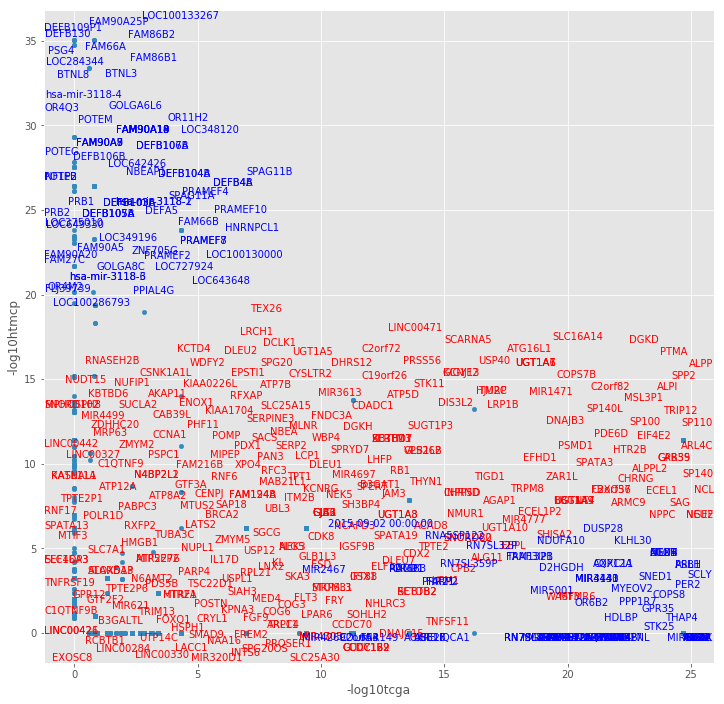

In [43]:

dfm=dfm.fillna(1)
dfm.rename(index={'MLL2':'KMT2D'}, inplace=True)
dfm.plot.scatter(var1, var2, figsize=(12,12)) #, xlim=(-2, 40), ylim=(-2, 40))
# plt.hlines(1, 0, 50, colors='r', linestyles='dashed')
# plt.vlines(1, 0, 12, colors='r', linestyles='dashed')
# plt.ylabel('-log10(q)', fontsize=10)
dfn = dfm[(dfm[var1] > 5)&(dfm[var2] > 5)]
# dfn = dfm[(dfm[var1] > .6)&(dfm[var2] > .6)|(dfm[var1] > 10)|(dfm[var2] > 20)]
text1 = [plt.text(a, b, c, color='red') for a, b, c in zip(dfn[var1], dfn[var2], dfn.index)]
adjust_text(text1)


ix= dfn.index





dfn2 = dfm[(dfm[var1] > 20)|(dfm[var2] > 20)]

# texts = text1+text2
ix2 = dfn2.index
to_drop = [i for i in ix2 if i in ix]
to_drop
ix3 = dfn2.index.drop(to_drop)
dfn3 = dfn2.loc[ix3,]
# text3 = [i for i in text2 if i not in text1]
text3 = [plt.text(a, b, c, color='blue') for a, b, c in zip(dfn3[var1], dfn3[var2], dfn3.index)]
adjust_text(text3)

of = f'{wkdir}htmcp_tcga_shared_uniq_del_genes.png'
%time plt.savefig(of, bbox_inches='tight',dpi=200)
plt.show()

In [310]:
dfamp = dfm.copy()

In [487]:
# files = ['/home/szong/bin/GISTIC_2_0_22/124_patient_adj_hiv_pos/del_genes.conf_99.txt', 
#          '/home/szong/bin/GISTIC_2_0_22/124_patient_adj_hiv_pos/amp_genes.conf_99.txt'] 
# files = ['/home/szong/bin/GISTIC_2_0_22/124_patient_adj_3k_0.1_1Mb/del_genes.conf_99.txt',
#          '/home/szong/bin/GISTIC_2_0_22/124_patient_adj_3k_0.1_1Mb/amp_genes.conf_99.txt']
files = ['/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/124_patient_adj_hiv_pos/del_genes.conf_99.txt',
#         '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/124_patient_adj_hiv_pos/amp_genes.conf_99.txt']
for inf in files:
    df1 = summarize_genes(inf, tgs)

write summary for /projects/trans_scratch/validations/workspace/szong/Cervical/cnv/124_patient_adj_hiv_pos/del_genes.conf_99.txt
write summary for /projects/trans_scratch/validations/workspace/szong/Cervical/cnv/124_patient_adj_hiv_pos/amp_genes.conf_99.txt


In [488]:
# files = ['/home/szong/bin/GISTIC_2_0_22/124_patient_adj_hiv_neg/del_genes.conf_99.txt', 
#          '/home/szong/bin/GISTIC_2_0_22/124_patient_adj_hiv_neg/amp_genes.conf_99.txt'] 
# files = ['/home/szong/bin/GISTIC_2_0_22/124_patient_adj_3k_0.1_1Mb/del_genes.conf_99.txt', 
# '/home/szong/bin/GISTIC_2_0_22/124_patient_adj_3k_0.1_1Mb/amp_genes.conf_99.txt']
files = ['/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/124_patient_adj_hiv_neg/del_genes.conf_99.txt',
        '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/124_patient_adj_hiv_neg/amp_genes.conf_99.txt']

for inf in files:
    df1 = summarize_genes(inf, tgs)

write summary for /projects/trans_scratch/validations/workspace/szong/Cervical/cnv/124_patient_adj_hiv_neg/del_genes.conf_99.txt
write summary for /projects/trans_scratch/validations/workspace/szong/Cervical/cnv/124_patient_adj_hiv_neg/amp_genes.conf_99.txt


In [489]:
%%bash
cd /projects/trans_scratch/validations/workspace/szong/Cervical/cnv/124_patient_adj_hiv_pos
cat del_genes.conf_99.txt.summary |awk -F ":" '{print $1"\t"$2}'|sed 's/chr//g'|sort -k4n> del_genes.conf_99.txt.summary.sorted
cat amp_genes.conf_99.txt.summary |awk -F ":" '{print $1"\t"$2}'|sed 's/chr//g'|sort -k4n> amp_genes.conf_99.txt.summary.sorted

cd /projects/trans_scratch/validations/workspace/szong/Cervical/cnv/124_patient_adj_hiv_neg
cat del_genes.conf_99.txt.summary |awk -F ":" '{print $1"\t"$2}'|sed 's/chr//g'|sort -k4n> del_genes.conf_99.txt.summary.sorted
cat amp_genes.conf_99.txt.summary |awk -F ":" '{print $1"\t"$2}'|sed 's/chr//g'|sort -k4n> amp_genes.conf_99.txt.summary.sorted

In [192]:
def get_qvalue_cytoband(f):
    df = pd.read_csv(f, sep='\t')
    df['gene'] = df['oncogenes'].apply(lambda x: x.split(')')[1])
    df = df[['q value','cytoband', 'gene']]
    df = df[df.gene != '']
    s = df["gene"].str.split(',', expand=True).stack()
    i = s.index.get_level_values(0)
    df2 = df.loc[i].copy()
    df2["gene"] = s.values
    return df2

In [272]:
def map_two_columns(x1, x2):
    if 'q' in x1 or 'p' in x1:
        return x1
    elif 'q' in x2 or 'p' in x2:
        return x2
    else:
        return 'error'
    

In [280]:
# for amps
# pos_amp_file = '/home/szong/bin/GISTIC_2_0_22/124_patient_adj_hiv_pos/amp_genes.conf_99.txt.summary.sorted'
pos_amp_file = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/124_patient_adj_hiv_pos/amp_genes.conf_99.txt.summary.sorted'
pos_amps = get_qvalue_cytoband(pos_amp_file)
pos_amps.head(2)

# neg_amp_file = '/home/szong/bin/GISTIC_2_0_22/124_patient_adj_hiv_neg/amp_genes.conf_99.txt.summary.sorted'
neg_amp_file = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/124_patient_adj_hiv_neg/amp_genes.conf_99.txt.summary.sorted'
neg_amps = get_qvalue_cytoband(neg_amp_file)
neg_amps.head(2)

ndf = pd.merge(pos_amps, neg_amps, left_on='gene', right_on='gene', how='outer')#.fillna(1)
ndf.columns = ['hiv+q', 'cytoband_pos','gene', 'hiv-q', 'cytoband_neg']
ndf['cytoband'] = ndf.astype(str).apply(lambda x: map_two_columns(x1=x['cytoband_pos'], x2=x['cytoband_neg']), axis=1)

ndf = ndf.drop(['cytoband_pos', 'cytoband_neg'], axis=1)
ndf.head(2)

,q value,cytoband,gene
7,0.003377,2q31.1,NFE2L2
7,0.003377,2q31.1,HOXD11


,q value,cytoband,gene
2,0.19405,2p25.3,C2orf44
2,0.19405,2p25.3,NCOA1


,hiv+q,gene,hiv-q,cytoband
0,0.003377,NFE2L2,NaN,2q31.1
1,0.003377,HOXD11,NaN,2q31.1


In [281]:
of = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/amp_gene_qvalue_comparison_hiv_pos_vs_neg.txt'
ndf.to_csv(of, sep='\t', index=False)

In [314]:
# for dels
pos_del_file = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/124_patient_adj_hiv_pos/del_genes.conf_99.txt.summary.sorted'
pos_dels = get_qvalue_cytoband(pos_del_file)
pos_dels.head(2)

neg_del_file = '//projects/trans_scratch/validations/workspace/szong/Cervical/cnv/124_patient_adj_hiv_neg/del_genes.conf_99.txt.summary.sorted'
neg_dels = get_qvalue_cytoband(neg_del_file)
neg_dels.head(2)

ndf = pd.merge(pos_dels, neg_dels, left_on='gene', right_on='gene', how='outer')#.fillna(1)
ndf.columns = ['hiv+q', 'cytoband_pos','gene', 'hiv-q', 'cytoband_neg']
ndf['cytoband'] = ndf.astype(str).apply(lambda x: map_two_columns(x1=x['cytoband_pos'], x2=x['cytoband_neg']), axis=1)

ndf = ndf.drop(['cytoband_pos', 'cytoband_neg'], axis=1)
ndf.head(2)

,q value,cytoband,gene
0,0.055942,1p36.21,MDS2
0,0.055942,1p36.21,PARK7


,q value,cytoband,gene
0,0.039246,1p13.2,GSTM1
0,0.039246,1p13.2,RAP1A


,hiv+q,gene,hiv-q,cytoband
0,0.055942,MDS2,NaN,1p36.21
1,0.055942,PARK7,NaN,1p36.21


In [92]:
ndf.shape
ndf['gene'].nunique()

(431, 3)

414

In [93]:
# look at duplicated on column gene
pd.concat(g for _, g in ndf.groupby("gene") if len(g) > 1).head(2)

,hiv+q,gene,hiv-q
20,1.795800e-19,ACSL3,1.0
21,1.855100e-18,ACSL3,1.0


In [315]:
ndf = ndf.drop_duplicates(subset='gene', keep='last')

In [283]:
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    k = 0
    j = 0 
    for i, point in a.iterrows():
        _ = ax.text(point['x']+j, point['y']+k, str(point['val']))
        k+=1
#         j+=.5
    return a

In [36]:
def plot_genes(ax, df):
    df = df.sort_values(['y', 'x'], ascending=True)
    for ix, row in df.iterrows():  
        gene = row.gene
        x = row['hiv+q']
        y = row['hiv-q']
        textx = row.x
        texty = row.y
#         anno_color = row.anno_color
#         anno_ecolor = row.anno_ecolor
#         arrow_color = row.arrow_color
#         fill_color = row.fill_color
        anno_color = 'blue'
        arrow_color = 'blue'
        ax.annotate('{}'.format(gene),
                    xy=(x,y), 
                    xytext=(textx, texty), fontsize=10,
                    ha='center', va='bottom', color=anno_color,
                    textcoords='data', xycoords="data", 
                    bbox=dict(boxstyle='round', 
#                               fc=fill_color, 
#                               edgecolor=anno_ecolor,
                              alpha=1, pad=.4),
                    arrowprops=dict(arrowstyle='-', 
                                    color=anno_color,
                                    shrinkB=0, 
                                    connectionstyle='arc3,rad=0.0' 
                                  ))

In [10]:
ndf = ndf.sort_values('hiv-q')

In [318]:
of = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/del_gene_qvalue_comparison_hiv_pos_vs_neg.txt'
ndf = pd.read_csv(of, sep='\t').fillna(1)
ndf.head(2)

,hiv+q,gene,hiv-q,cytoband
0,0.055942,MDS2,1.0,1p36.21
1,0.055942,PARK7,1.0,1p36.21


In [319]:
ndf['hiv+q(-log10)'] = -np.log10(ndf['hiv+q'])
ndf['hiv-q(-log10)'] = -np.log10(ndf['hiv-q'])

In [320]:
ndf.head()
ndf.shape

,hiv+q,gene,hiv-q,cytoband,hiv+q(-log10),hiv-q(-log10)
0,0.055942,MDS2,1.0,1p36.21,1.252262,-0.0
1,0.055942,PARK7,1.0,1p36.21,1.252262,-0.0
2,0.055942,RAP1GAP,1.0,1p36.21,1.252262,-0.0
3,0.055942,KIF1B,1.0,1p36.21,1.252262,-0.0
4,0.055942,SDHB,1.0,1p36.21,1.252262,-0.0


(414, 6)

Text(0.5,1,'GISTIC dels oncogenes')

(-1, 23)

(-1, 23)

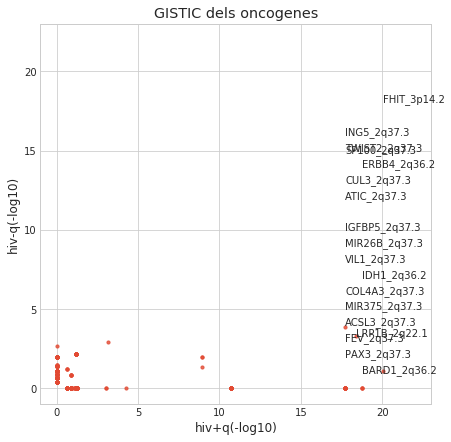

In [321]:
# Set theme
sns.set_style('whitegrid')


# Scatterplot arguments
# grid = sns.lmplot(x='hiv+q', y='hiv-q', data=ndf.fillna(.1),
#            fit_reg=False) # No regression line
#            #hue='Stage')   # Color by evolution stage
# # Tweak using Matplotlib
# # plt.ylim(0, .2)
# # plt.xlim(0, .2)
# grid.set(xscale="log", yscale="log")

f, ax = plt.subplots(figsize=(7, 7))


# ax.set(xscale="log", yscale="log")
sns.regplot(x='hiv+q(-log10)', y='hiv-q(-log10)', data=ndf, ax=ax, fit_reg=False, x_jitter=1e-12, y_jitter=1e-10, scatter_kws={"s": 10})




ax.set_title('GISTIC dels oncogenes')
ax.set_xlim(-1, 23)
ax.set_ylim(-1, 23)



    
ndf = ndf[(ndf['hiv+q(-log10)']>15)]#|(ndf['hiv-q(-log10)']>5)]
_ = label_point(ndf['hiv+q(-log10)'], ndf['hiv-q(-log10)'], ndf['gene']+'_'+ndf['cytoband'], plt.gca())  
of = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/del_gene_qvalue_comparison_hiv_pos_vs_neg.png'
plt.savefig(of, bbox_inches='tight', dpi=200)

In [126]:
plt.close()

In [18]:
ndf.head(2)

,hiv+q,gene,hiv-q
23,1.0,TP63,1.264200e-10
25,1.0,MYC,5.258800e-03


In [316]:
of = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/del_gene_qvalue_comparison_hiv_pos_vs_neg.txt'
ndf.to_csv(of, sep='\t', index=False)

In [9]:
%%bash
cd /home/szong/bin/GISTIC_2_0_22/124_patient_adj_hiv_neg
cat del_genes.conf_99.txt.summary |awk -F ":" '{print $1"\t"$2}'|sed 's/chr//g'|sort -k4n> del_genes.conf_99.txt.summary.sorted
cat amp_genes.conf_99.txt.summary |awk -F ":" '{print $1"\t"$2}'|sed 's/chr//g'|sort -k4n> amp_genes.conf_99.txt.summary.sorted

# look at correlation between copy number and expression

In [49]:
df2

,q value,gene,new_gene
7,3.377000e-03,"NFE2L2,HOXD11,HOXD13",NFE2L2
7,3.377000e-03,"NFE2L2,HOXD11,HOXD13",HOXD11
7,3.377000e-03,"NFE2L2,HOXD11,HOXD13",HOXD13
9,8.332900e-13,DLG1,DLG1
16,5.524600e-02,RAC1,RAC1
20,6.399600e-05,ESRP1,ESRP1
22,8.899700e-02,UHRF2,UHRF2
26,1.518200e-01,"LMO2,EHF",LMO2
26,1.518200e-01,"LMO2,EHF",EHF
28,5.902500e-07,"YAP1,BIRC3",YAP1


In [ ]:
f = '/home/szong/bin/GISTIC_2_0_22/124_patient_adj_3k_0.1_1Mb/all_thresholded.by_genes.txt'
df = pd.read_csv(f, sep='\t')
df.head(2)

In [ ]:
f1 = '/projects/trans_scratch/validations/workspace/szong/Cervical/expression/NCI_ensembl69_stranded_RPKM_matrix.txt'
df1 = pd.read_csv(f1, sep='\t')
df1.head(2)

In [ ]:
genes = ['ECT2', 'YAP1', 'DLG1',  'DNAH5',  'SP100', 'STK11']

In [ ]:
def categorize_cnv(i):
#     for i in s:
    if i < 0:
        cat = 'cnv_loss'
    elif i > 0:
        cat = 'cnv_gain'
    else: cat = 'cnv_neutral'
#         ns.append(cat)
    return cat

In [ ]:
with plt.style.context("seaborn-whitegrid"):
    plt.rcParams["axes.edgecolor"] = "0.15"
    plt.rcParams["axes.linewidth"]  = 1.25
    fig = plt.figure(facecolor='w', figsize=(12,12))
    axes = (fig.subplots(int(len(genes)/3), 3)).ravel()
#     print(axes[1])
    for i, gene in enumerate(genes):
        dfgene = df[df['Gene Symbol'] == gene]
        df1gene = df1[df1.genes.str.contains('_{}$'.format(gene))]
        dff = pd.concat([dfgene, df1gene]).drop(['Cytoband', 'Gene Symbol', 'Locus ID', 'genes'], axis=1).T
        dff.columns = ['cnv', 'rpkm']
#         dff['groups'] = ['cnv_loss' if i< 0 'cnv_gain' elif i>0 else 'cnv_neutral' for i in dff.cnv ]
        dff['groups'] = dff.cnv.apply(categorize_cnv)
#         print(dff['groups'].unique())
        # boxplot overlaps individual data point

        ax = axes[i]
        _ = sns.boxplot('groups', 'rpkm', data=dff, ax=ax, order=['cnv_loss', 'cnv_neutral', 'cnv_gain'])
        _ = sns.swarmplot('groups', 'rpkm', data=dff, ax=ax, order=['cnv_loss', 'cnv_neutral', 'cnv_gain'])
        _ = ax.set_title(gene)
        _ = ax.set_xlabel('')
        grps = {}
        # overlay actuall data point
        categories = ['cnv_loss','cnv_neutral', 'cnv_gain']
        group_col = 'groups'
        value_col = 'rpkm'
        for i, cat in enumerate(categories):
#             print(i, cat)
            grps[i] = dff.query('{0} == "{1}"'.format(group_col, cat))[value_col]

        if len(categories) == 2:
            # statistical test for 1st grp
#             sts, p = ss.mannwhitneyu(grps[0], grps[1], use_continuity=True, alternative=None)
            sts, p1 = ttest_ind(grps[0], grps[1])
#             print(p)
            p = round(p, 8)
            _ = ax.text(0.4 , 0.90,'p={}'.format(p), ha='center', va='center', transform=ax.transAxes, size=14)
        elif len(categories) == 3:
            # statistical test for 1st grp
#             sts, p1 = ss.mannwhitneyu(grps[0], grps[1], use_continuity=True, alternative=None)
            sts, p1 = ttest_ind(grps[0], grps[1])
#             print(p1)
            p1 = round(p1, 5)
            _ = ax.text(0.2 , 0.90,'p={}'.format(p1), ha='center', va='center', transform=ax.transAxes, size=14)
#             sts, p2 = ss.mannwhitneyu(grps[2], grps[1], use_continuity=True, alternative=None)
            sts, p2 = ttest_ind(grps[2], grps[1])
#             print(p2)
            p2 = round(p2, 5)
            _ = ax.text(0.7 , 0.90,'p={}'.format(p2), ha='center', va='center', transform=ax.transAxes, size=14)
    of = '/projects/trans_scratch/validations/workspace/szong/Cervical/cnv/cnv_expression.png'
    plt.savefig(of, dpi=200)